# Resistance/Support Strategy

In [18]:
import pandas as pd
import pandas_ta as ta
#df = pd.read_csv("EURUSD_Candlestick_1_D_ASK_05.05.2003-30.06.2021.csv")
df = pd.read_csv("EURUSD_Candlestick_1_Hour_BID_04.05.2003-15.04.2023.csv")
#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df['RSI'] = ta.rsi(df.close, length=12)
df.tail()

df=df[0:2000]

# Support and Resitance FUNCTIONS

In [19]:
wick_threshold = 0.0001

def support(df1, l, n1, n2): #n1 n2 before and after candle l
    if ( df1.low[l-n1:l].min() < df1.low[l] or
        df1.low[l+1:l+n2+1].min() < df1.low[l] ):
        return 0

    # current candel have to be pivot low and wick > wick_threshold and wick > candle_body
    candle_body = abs(df1.open[l]-df1.close[l])
    lower_wick = min(df1.open[l], df1.close[l])-df1.low[l]
    if (lower_wick > candle_body) and (lower_wick > wick_threshold): 
        return 1
    
    return 0

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    if ( df1.high[l-n1:l].max() > df1.high[l] or
       df1.high[l+1:l+n2+1].max() > df1.high[l] ):
        return 0

    # current candel have to be pivot high and wick > wick_threshold and wick > candle_bod
    candle_body = abs(df1.open[l]-df1.close[l])
    upper_wick = df1.high[l]-max(df1.open[l], df1.close[l])
    if (upper_wick > candle_body) and (upper_wick > wick_threshold) :
        return 1

    return 0

In [20]:
def closeResistance(l,levels,lim, df):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return min(levels, key=lambda x:abs(x-df.high[l]))
    else:
        return 0
    
def closeSupport(l,levels,lim, df):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return min(levels, key=lambda x:abs(x-df.low[l]))
    else:
        return 0

In [21]:
def is_below_resistance(l, level_backCandles, level, df):
    return df.loc[l-level_backCandles:l-1, 'high'].max() < level

def is_above_support(l, level_backCandles, level, df):
    return df.loc[l-level_backCandles:l-1, 'low'].min() > level        

In [22]:
def check_candle_signal(l, n1, n2, backCandles, df):
    # support and resistance list
    ss = []
    rr = []
    for subrow in range(l-backCandles, l-n2):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    
    ss.sort() #keep lowest support when popping a level
    for i in range(1,len(ss)):
        if(i>=len(ss)):
            break
        if abs(ss[i]-ss[i-1])<=0.0001: # merging close distance levels
            ss.pop(i)

    rr.sort(reverse=True) # keep highest resistance when popping one
    for i in range(1,len(rr)):
        if(i>=len(rr)):
            break
        if abs(rr[i]-rr[i-1])<=0.0001: # merging close distance levels
            rr.pop(i)

    #----------------------------------------------------------------------
    # joined levels
    rrss = rr+ss
    rrss.sort()
    for i in range(1,len(rrss)):
        if(i>=len(rrss)):
            break
        if abs(rrss[i]-rrss[i-1])<=0.0001: # merging close distance levels
            rrss.pop(i)
    cR = closeResistance(l, rrss, 150e-5, df)
    cS = closeSupport(l, rrss, 150e-5, df)
    #----------------------------------------------------------------------

    # cR = closeResistance(l, rr, 150e-5, df)
    # cS = closeSupport(l, ss, 150e-5, df)
    # could we consider the average RSI for the trend momentum?
    if (cR and is_below_resistance(l,6,cR, df) and df.RSI[l-1:l].min()<45 ):#and df.RSI[l]>65
        return 1
    elif(cS and is_above_support(l,6,cS,df) and df.RSI[l-1:l].max()>55 ):#and df.RSI[l]<35
        return 2
    else:
        return 0



In [23]:
# Add progress bar
from tqdm import tqdm

n1 = 8
n2 = 6
backCandles = 140

signal = [0 for i in range(len(df))]

for row in tqdm(range(backCandles+n1, len(df)-n2)):
    signal[row] = check_candle_signal(row, n1, n2, backCandles, df)

df["signal"] = signal


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:33<00:00, 54.35it/s]


In [24]:
df[df['signal']==1].count()

Gmt time    42
open        42
high        42
low         42
close       42
volume      42
RSI         42
signal      42
dtype: int64

In [29]:
df[ (df['signal']==1) | (df['signal']==2)]

,Gmt time,open,high,low,close,volume,RSI,signal,pointpos
179,14.05.2003 08:00:00.000,1.14720,1.15260,1.14667,1.15203,2.759340e+07,52.947000,1,1.15270
228,16.05.2003 09:00:00.000,1.14057,1.14217,1.13990,1.14198,2.669290e+07,53.093655,1,1.14227
256,19.05.2003 13:00:00.000,1.16598,1.16761,1.16274,1.16736,2.604230e+07,61.195997,2,1.16264
261,19.05.2003 18:00:00.000,1.16786,1.16801,1.16374,1.16585,1.466139e+08,52.400581,2,1.16364
274,20.05.2003 07:00:00.000,1.16695,1.16749,1.16351,1.16433,2.704080e+07,46.666791,2,1.16341
...,...,...,...,...,...,...,...,...,...
1923,25.08.2003 06:00:00.000,1.08710,1.08789,1.08669,1.08699,3.187730e+07,42.511745,1,1.08799
1924,25.08.2003 07:00:00.000,1.08711,1.08831,1.08688,1.08805,3.129550e+07,49.068385,1,1.08841
1955,26.08.2003 14:00:00.000,1.08165,1.08801,1.08092,1.08798,3.150230e+07,61.222415,1,1.08811
1970,27.08.2003 05:00:00.000,1.08372,1.08684,1.08370,1.08665,3.104610e+07,52.983432,1,1.08694


In [30]:
import numpy as np
def pointpos(x):
    if x['signal']==1:
        return x['high']+1e-4
    elif x['signal']==2:
        return x['low']-1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

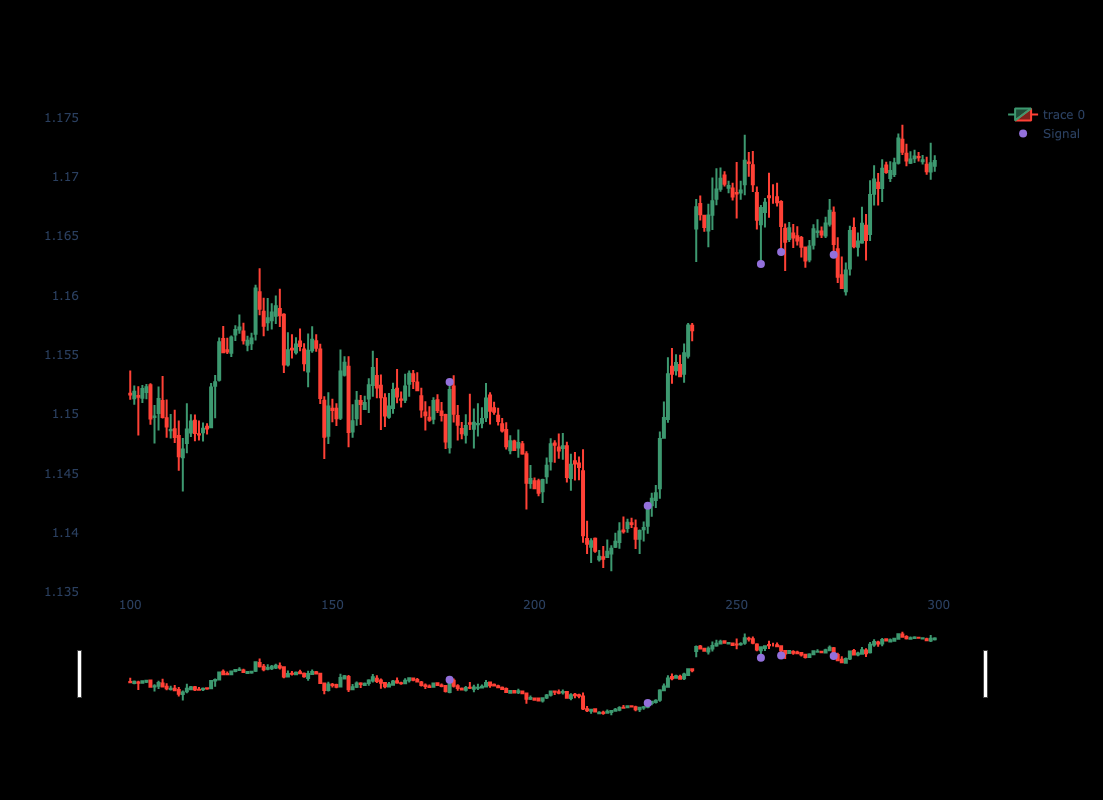

In [31]:
dfpl = df[100:300]
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close'])])

fig.update_layout(
    autosize=False,
    width=1000,
    height=800, 
    paper_bgcolor='black',
    plot_bgcolor='black')
fig.update_xaxes(gridcolor='black')
fig.update_yaxes(gridcolor='black')
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=8, color="MediumPurple"),
                name="Signal")
fig.show()

In [37]:
def check_candle_signal_plot(l, n1, n2, backCandles, df, proximity):
    ss = []
    rr = []
    for subrow in range(l-backCandles, l-n2):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    
    ss.sort() #keep lowest support when popping a level
    i = 0
    while i < len(ss)-1:
        if abs(ss[i]-ss[i+1]) <= proximity:
            # ss[i] = (ss[i]+ss[i+1])/2
            # del ss[i+1]
            del ss[i+1]
        else:
            i+=1

    rr.sort(reverse=True) # keep highest resistance when popping one
    i = 0
    while i < len(rr)-1:
        if abs(rr[i]-rr[i+1]) <= proximity:
            #rr[i] = (rr[i]+rr[i+1])/2
            #del rr[i+1]
            del rr[i]
        else:
            i+=1

    import plotly.graph_objects as go
    dfpl=df[l-backCandles-n1:l+n2+50]
    fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close'])])

    c=0
    while (1):
        if(c>len(ss)-1 ):
            break
        fig.add_shape(type='line', x0=l-backCandles-n1, y0=ss[c],
                    x1=l,
                    y1=ss[c],
                    line=dict(color="MediumPurple",width=2), name="Support"
                    )
        c+=1

    c=0
    while (1):
        if(c>len(rr)-1 ):
            break
        fig.add_shape(type='line', x0=l-backCandles-n1, y0=rr[c],
                    x1=l,
                    y1=rr[c],
                    line=dict(color="Red",width=2), name="Resistance"
                    )
        c+=1    

    # fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
    #             marker=dict(size=5, color="MediumPurple"),
    #             name="Signal")

    fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
    
    fig.show()
 
 
    #----------------------------------------------------------------------
    cR = closeResistance(l, rr, 150e-5, dfpl)
    cS = closeSupport(l, ss, 150e-5, dfpl)
    #print(cR, is_below_resistance(l,6,cR, dfpl))

    if (cR and is_below_resistance(l,6,cR, dfpl) ):#and df.RSI[l]>65     # bearish signal
        return 1
    elif(cS and is_above_support(l,6,cS,dfpl) ):#and df.RSI[l]<35  # bullish signal
        return 2
    else:
        return 0

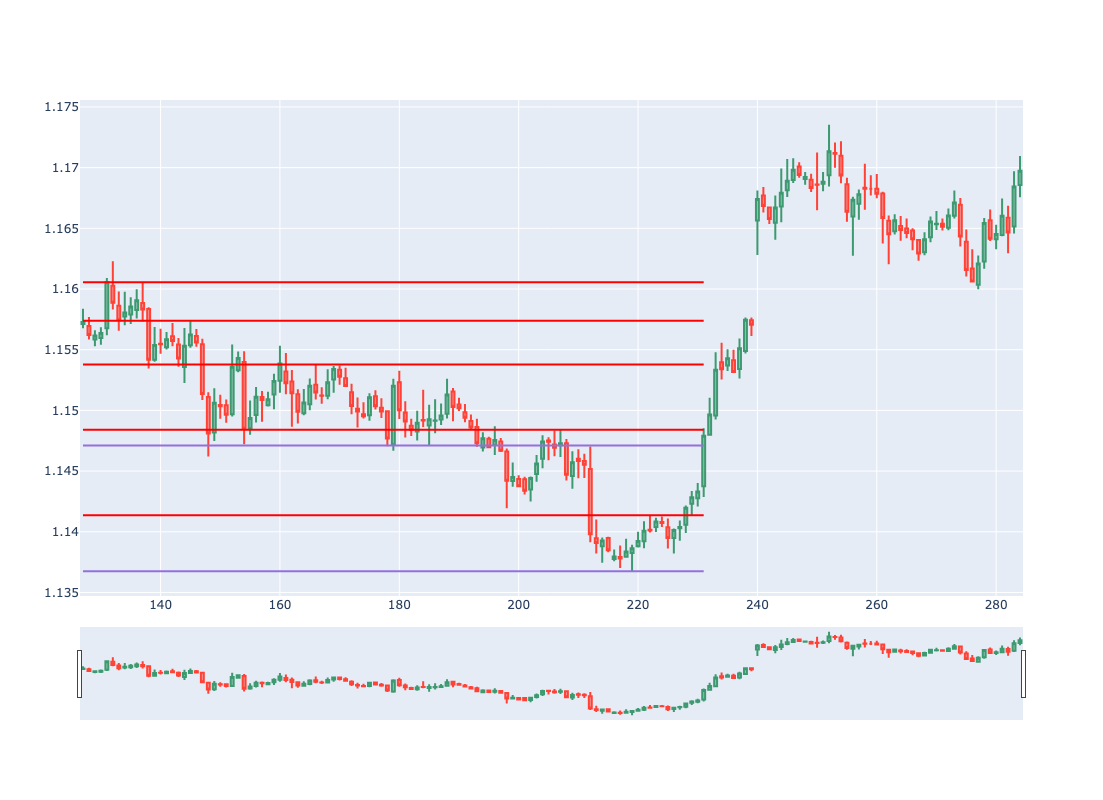

1

In [36]:
check_candle_signal_plot(231, 4,4,100,df,0.002)